In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
import string
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import chart_studio.plotly  as py
import plotly.graph_objs as go

Using TensorFlow backend.


In [3]:
df = pd.read_csv('/Users/yashpasar/Downloads/yelp_sentiment.csv')

In [4]:
df.head()

,reviews,sentiment
0,Wow... Loved this place.,p
1,Crust is not good.,n
2,Not tasty and the texture was just nasty.,n
3,Stopped by during the late May bank holiday of...,p
4,The selection on the menu was great and so wer...,p


In [5]:
print("Null values in the dataset:") 
df.isnull().sum()

Null values in the dataset:


reviews      0
sentiment    0
dtype: int64

In [6]:
df['Word Count'] = [len(review.split()) for review in df['reviews']]

df['Uppercase Char Count'] = [sum(char.isupper() for char in review) \
                              for review in df['reviews']]                           

df['Special Char Count'] = [sum(char in string.punctuation for char in review) \
                            for review in df['reviews']]

In [7]:
df.head()

,reviews,sentiment,Word Count,Uppercase Char Count,Special Char Count
0,Wow... Loved this place.,p,4,2,4
1,Crust is not good.,n,4,1,1
2,Not tasty and the texture was just nasty.,n,8,1,1
3,Stopped by during the late May bank holiday of...,p,15,4,1
4,The selection on the menu was great and so wer...,p,12,1,1


In [8]:
positive_samples = df[df['sentiment'] == 'p']
negative_samples = df[df['sentiment'] == 'n']

## Word Count

In [9]:
positive_samples['Word Count'].describe()

count    494.000000
mean      10.275304
std        5.836265
min        1.000000
25%        5.250000
50%        9.000000
75%       13.000000
max       32.000000
Name: Word Count, dtype: float64

In [10]:
negative_samples['Word Count'].describe()

count    494.000000
mean      11.728745
std        8.687457
min        2.000000
25%        6.000000
50%       10.000000
75%       16.000000
max      137.000000
Name: Word Count, dtype: float64

## Uppercase Character Count

In [11]:
positive_samples['Uppercase Char Count'].describe()

count    494.000000
mean       1.724696
std        1.657584
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       14.000000
Name: Uppercase Char Count, dtype: float64

In [12]:
negative_samples['Uppercase Char Count'].describe()

count    494.000000
mean       2.082996
std        3.842117
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       55.000000
Name: Uppercase Char Count, dtype: float64

## Special Character Count

In [13]:
positive_samples['Special Char Count'].describe()

count    494.000000
mean       1.544534
std        1.481817
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       19.000000
Name: Special Char Count, dtype: float64

In [14]:
negative_samples['Special Char Count'].describe()

count    494.000000
mean       1.674089
std        1.782566
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       31.000000
Name: Special Char Count, dtype: float64

In [15]:
df.sentiment.value_counts()

p    494
n    494
Name: sentiment, dtype: int64

In [16]:
color_palette_list = ['#009ACD', '#ADD8E6']
labels = ['Positive words', 
          'Negative words']
percentages = [50, 50]
trace = go.Pie(labels=labels, 
               hoverinfo='label+percent', 
               values=percentages, 
               textposition='outside',
               marker=dict(colors=color_palette_list),
               rotation=90)
layout = go.Layout(
                    title="Count of positive and negative words",
                    font=dict(family='Arial', size=12, color='#909090'),
                    legend=dict(x=0.9, y=0.5)
                    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic_pie_chart')

In [17]:
from collections import Counter

def getMostCommonWords(reviews, n_most_common, stopwords=None):
    # param reviews: column from pandas.DataFrame (e.g. df['Reviews']) 
        #(pandas.Series)
    # param n_most_common: the top n most common words in reviews (int)
    # param stopwords: list of stopwords (str) to remove from reviews (list)
    # Returns list of n_most_common words organized in tuples as 
        #('term', frequency) (list)

    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove stopwords, if applicable
    if stopwords:
        flattened_reviews = [word for word in flattened_reviews if \
                             word not in stopwords]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

## Positive Class with Stopwords

In [18]:
getMostCommonWords(positive_samples['reviews'], 10)

[('the', 306),
 ('and', 219),
 ('was', 137),
 ('i', 116),
 ('a', 110),
 ('is', 102),
 ('to', 87),
 ('this', 74),
 ('good', 72),
 ('great', 69)]

## Positive Class without Stopwords

In [19]:
getMostCommonWords(positive_samples['reviews'], 10, stopwords.words('english'))

[('good', 72),
 ('great', 69),
 ('food', 59),
 ('place', 54),
 ('service', 46),
 ('friendly', 23),
 ('delicious', 23),
 ('back', 23),
 ('nice', 22),
 ('best', 22)]

## Negative Class with Stopwords

In [20]:
getMostCommonWords(negative_samples['reviews'], 10)

[('the', 276),
 ('i', 188),
 ('and', 170),
 ('was', 157),
 ('to', 132),
 ('a', 126),
 ('not', 97),
 ('it', 83),
 ('of', 74),
 ('this', 69)]

## Negative Class without Stopwords

In [21]:
getMostCommonWords(negative_samples['reviews'], 10, stopwords.words('english'))

[('food', 64),
 ('place', 52),
 ('back', 38),
 ('service', 37),
 ('like', 29),
 ('go', 26),
 ('dont', 25),
 ('good', 22),
 ('would', 21),
 ('never', 21)]

In [22]:
df.drop(columns=['Word Count', 'Uppercase Char Count', 'Special Char Count'], inplace=True)

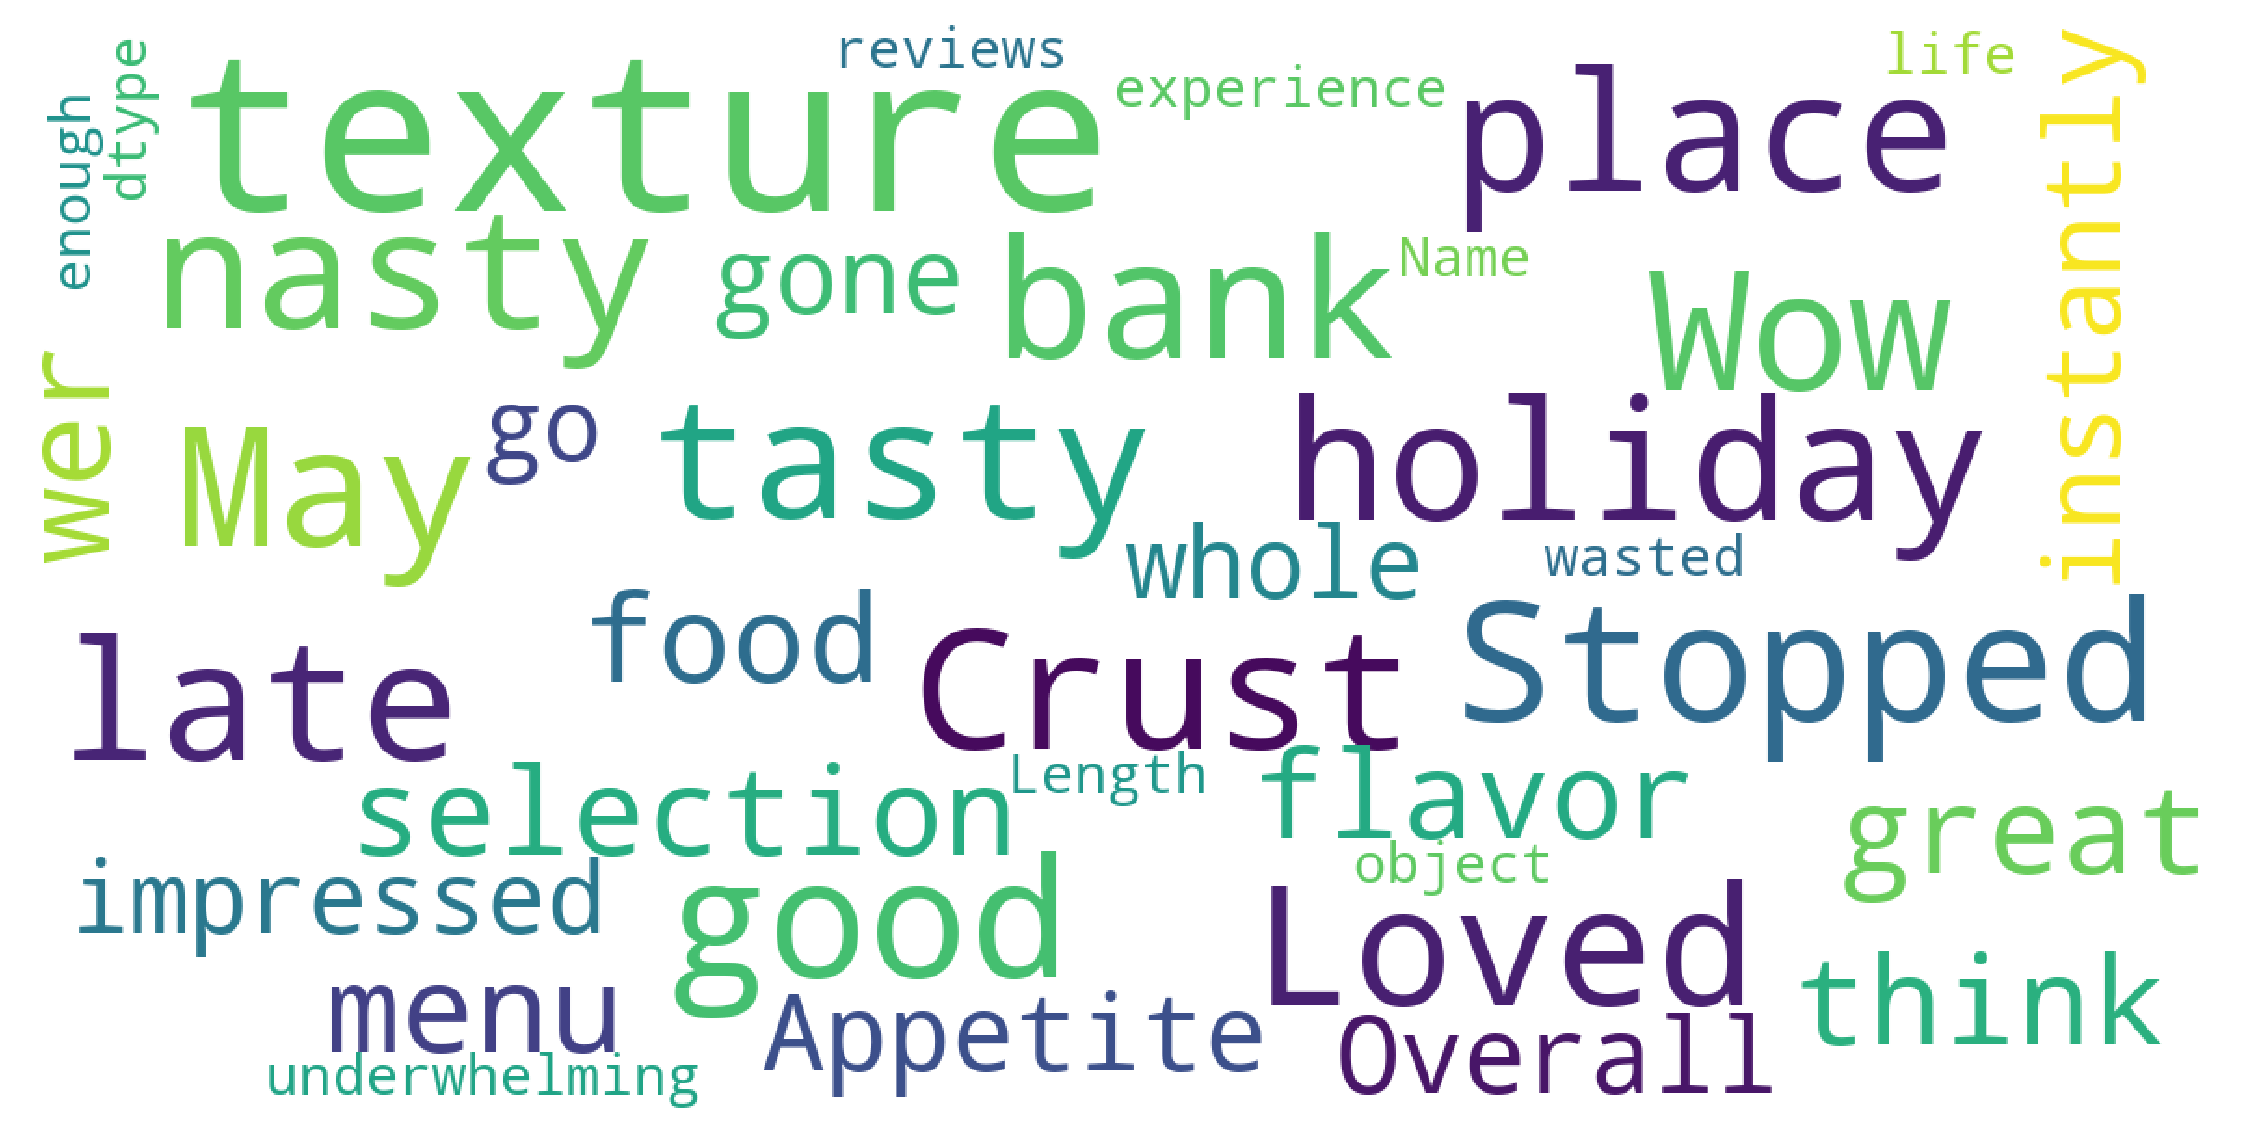

In [23]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["reviews"])

# Pre processing
## Perform following NLP task on data-
### 1. Lower case
### 2. Remove punctuation
### 3. Remove stop words
### 4. Stem the words 

In [24]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["cleaned_reviews"] = df["reviews"].apply(lambda x: clean_text(x))

In [25]:
df.head()

,reviews,sentiment,cleaned_reviews
0,Wow... Loved this place.,p,wow love place
1,Crust is not good.,n,crust good
2,Not tasty and the texture was just nasty.,n,tasty texture nasty
3,Stopped by during the late May bank holiday of...,p,stop late may bank holiday rick steve recommen...
4,The selection on the menu was great and so wer...,p,selection menu great price


In [26]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range =(1,2), min_df = 2, lowercase=True)
tfidf_result = tfidf.fit_transform(df["cleaned_reviews"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = [str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index

In [27]:
tfidf_df.head()
#tfidf_df.to_csv('Document Term Matrix.csv')

,10,10 minute,100,12,20,20 minute,30,30 min,30 minute,35,...,would recommend,wow,wrap,wrong,year,year ago,yet,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.614561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X = tfidf_df.values
y = df['sentiment'].values

## Train-Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(741, 963) (741,)
(247, 963) (247,)


# Logistic Regression

In [30]:
from sklearn.metrics import accuracy_score
for c in [0.01, 0.25, 0.5, 1, 5]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.6842105263157895
Accuracy for C=0.25: 0.708502024291498
Accuracy for C=0.5: 0.728744939271255
Accuracy for C=1: 0.7530364372469636
Accuracy for C=5: 0.7692307692307693


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [31]:
classifier = LogisticRegression(class_weight= 'balanced', penalty= 'l2',C=5)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score*100,'%')

Accuracy: 76.92307692307693 %


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [32]:
preds = classifier.predict(X_test)

In [33]:
print("Confusion matrix:")
print('\n')
print(confusion_matrix(y_test, preds))
print('\n')
print("Classification Report:")
print('\n')
print(classification_report(y_test, preds))

Confusion matrix:


[[106  15]
 [ 42  84]]


Classification Report:


              precision    recall  f1-score   support

           n       0.72      0.88      0.79       121
           p       0.85      0.67      0.75       126

    accuracy                           0.77       247
   macro avg       0.78      0.77      0.77       247
weighted avg       0.78      0.77      0.77       247



# Multinomial Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
predmnb = mnb.predict(X_test)
score = mnb.score(X_test, y_test)
print("Accuracy:", score*100,'%')
print("Confusion Matrix for Random Forest Classifier:")
print('\n')
print(confusion_matrix(y_test,predmnb))
print("Classification Report:")
print('\n')
print(classification_report(y_test, predmnb))

Accuracy: 78.13765182186235 %
Confusion Matrix for Random Forest Classifier:


[[103  18]
 [ 36  90]]
Classification Report:


              precision    recall  f1-score   support

           n       0.74      0.85      0.79       121
           p       0.83      0.71      0.77       126

    accuracy                           0.78       247
   macro avg       0.79      0.78      0.78       247
weighted avg       0.79      0.78      0.78       247



# ANN

In [35]:
df['sentiment'] = df['sentiment'].map({'n': 1, 'p': 0})

In [36]:
y = df['sentiment'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [38]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                9640      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 9,651
Trainable params: 9,651
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 741 samples, validate on 247 samples
Epoch 1/100
741/741 [==============================] - 0s 468us/step - loss: 0.6900 - accuracy: 0.5088 - val_loss: 0.6868 - val_accuracy: 0.5587
Epoch 2/100
741/741 [==============================] - 0s 179us/step - loss: 0.6730 - accuracy: 0.6599 - val_loss: 0.6739 - val_accuracy: 0.6275
Epoch 3/100
741/741 [==============================] - 0s 196us/step - loss: 0.6442 - accuracy: 0.7827 - val_loss: 0.6515 - val_accuracy: 0.7206
Epoch 4/100
741/741 [==============================] - 0s 179us/step - loss: 0.6002 - accuracy: 0.8286 - val_loss: 0.6223 - val_accuracy: 0.7490
Epoch 5/100
741/741 [==============================] - 0s 174us/step - loss: 0.5465 - accuracy: 0.8758 - val_loss: 0.5931 - val_accuracy: 0.7652
Epoch 6/100
741/741 [==============================] - 0s 178us/step - loss: 0.4914 - accuracy: 0.9015 - val_loss: 0.5670 - val_accuracy: 0.7490
Epoch 7/100
741/741 [==============================] - 0s 181us/step - loss: 0.4382 

In [40]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

score: 1.12
accuracy: 0.74


In [41]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 82,  44],
       [ 19, 102]])

In [43]:
print("Classification Report:")
print('\n')
print(classification_report(y_test, y_pred))

Classification Report:


              precision    recall  f1-score   support

           0       0.81      0.65      0.72       126
           1       0.70      0.84      0.76       121

    accuracy                           0.74       247
   macro avg       0.76      0.75      0.74       247
weighted avg       0.76      0.74      0.74       247



# Tuning ANN

In [44]:
neurons = [1, 5, 10]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
input_dim = X_train.shape[1]  # Number of features
def create_model(optimizer, activation, neurons):
    model = Sequential()
    model.add(layers.Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)

In [107]:
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs, activation=activation, neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=True)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 3024 candidates, totalling 9072 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 101.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 120.2min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 142.6min
[Parallel(n_jobs=-1)]: Done 9072 out of 9072 | elapsed: 150.5min finished


Best: 0.770580 using {'activation': 'relu', 'batch_size': 10, 'epochs': 50, 'neurons': 5, 'optimizer': 'RMSprop'}


In [45]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(5, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='RMSprop', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 4820      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 4,826
Trainable params: 4,826
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 741 samples, validate on 247 samples
Epoch 1/50
741/741 [==============================] - 0s 336us/step - loss: 0.6920 - accuracy: 0.5007 - val_loss: 0.6922 - val_accuracy: 0.5385
Epoch 2/50
741/741 [==============================] - 0s 232us/step - loss: 0.6868 - accuracy: 0.5830 - val_loss: 0.6892 - val_accuracy: 0.5668
Epoch 3/50
741/741 [==============================] - 0s 263us/step - loss: 0.6798 - accuracy: 0.5870 - val_loss: 0.6846 - val_accuracy: 0.5830
Epoch 4/50
741/741 [==============================] - 0s 237us/step - loss: 0.6700 - accuracy: 0.6437 - val_loss: 0.6784 - val_accuracy: 0.5668
Epoch 5/50
741/741 [==============================] - 0s 196us/step - loss: 0.6580 - accuracy: 0.6491 - val_loss: 0.6713 - val_accuracy: 0.5911
Epoch 6/50
741/741 [==============================] - 0s 184us/step - loss: 0.6442 - accuracy: 0.7099 - val_loss: 0.6637 - val_accuracy: 0.5709
Epoch 7/50
741/741 [==============================] - 0s 185us/step - loss: 0.6290 - accur

In [47]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

score: 0.59
accuracy: 0.78


In [48]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 86,  40],
       [ 15, 106]])

In [49]:
print("Classification Report:")
print('\n')
print(classification_report(y_test, y_pred))

Classification Report:


              precision    recall  f1-score   support

           0       0.85      0.68      0.76       126
           1       0.73      0.88      0.79       121

    accuracy                           0.78       247
   macro avg       0.79      0.78      0.78       247
weighted avg       0.79      0.78      0.78       247



### I think ANN model provides an accuracy of 78%when fine tuned but tuning the model takes a lot of time. In that scenario, algorithms like Naive Bayes and Logistic run very fast. Naive Bayes gave an impressive accuracy (78.13%) while taking minimal time. Hence Naive Bayes was considered as the best model as per my analysis. If we would have more data then I think ANN could have achieved even more accuracy.